# About

These is a base solution of PID.

In [1]:
%matplotlib inline
import pandas
import numpy
import matplotlib.pyplot as plt

import root_numpy

#RUN

In [2]:
params = {}

# Nets to track
params['TRACK'] = "Downstream" # "Long Downstream Upstream"
params['PARTICLE'] = "Electron" # "Electron Muon Pion Kaon Proton Ghost"


# General parameters
params['GHOSTACPTFRAC'] = 1.0
params['REUSETRAININGFILES'] = 0





# Classifier
params['MVATYPE'] = "TMVA"

# General Neural Network Options
params['MLPHIDDENLAYERSCALEF'] = 1.4
# TMVA Defaults
params['TMVAMETHOD'] = "MLP"
params['TMVAUSEREGULATOR'] = "true"
# MLP
params['TMVAMLPNCYCLES'] = "50" #!!!! 750
params['TMVAMLPNEURONTYPE'] = "sigmoid"
params['TMVAMLPMETHOD'] = "BP"
params['TMVAMLPESTIMATORTYPE'] = "CE"
params['TMVAMLPCONVIMPROVE'] = "1e-16"
params['TMVAMLPCONVTEST'] = "15"
# BDT
params['TMVABDTBOOSTTYPE'] = "AdaBoost"
params['TMVABDTNTREES'] = "800"
params['TMVAVARTRANSFORM'] = "Norm"
params['TMVABDTPRUNEMETHOD'] = "CostComplexity"
params['TMVABDTMAXTREEDEPTH'] = "3"





# Overall root dir
params['MAINROOT'] = ""
# Config directory
params['CONFIGDIR'] = params['MAINROOT'] + "configs"





# Network config
params['CONFIGNAME'] = "NoPreSels-NumSPDR1R2"
params['NNCONFIGNAME'] = params['MVATYPE'] + "-" + params['CONFIGNAME']
params['NNCONFIGDIR'] = params['CONFIGDIR'] + "/networks/" + params['NNCONFIGNAME']
params['NETCONFIG'] = params['NNCONFIGDIR'] + "/" + \
                      "GlobalPID_" + params['PARTICLE'] + "_" + params['TRACK'] + "_ANN.txt"
    
# Training config
params['TRAINCONFIGNAME'] = "test"
params['TRAINCONFIGDIR'] = params['CONFIGDIR'] + "/training/"
params['TRAINCONFIG'] = params['TRAINCONFIGDIR'] + \
                        params['MVATYPE'] + "-" + params['TRAINCONFIGNAME'] + ".txt"
    
# MVA Configuration
params['MVACONFIG'] = params['TRAINCONFIGDIR'] + "/MVA-Configuration.txt"
params['TMVAVALIDATIONFRAC'] = '0.3'
params['TMVATESTFRAC'] = '0.3'

# Preselection configs
params['TRACKSELCONFIGDIR'] = params['CONFIGDIR'] + "/TrackSelection/"





# Training data
params['DATAFILES'] = "MC12"
params['TRAININGDATA'] = "Mixture"
params['TRAINFILES'] = params['TRAINCONFIGDIR'] + "/" + params['DATAFILES'] + "-TrainingFiles-" + \
                       params['TRAININGDATA'] + "-Cambridge.txt"
    
    
# Eval data
params['EVALDATA'] = "Mixture"
params['EVALFILES'] = params['TRAINCONFIGDIR'] + "/" + params['DATAFILES'] + "-TrainingFiles-" + \
                      params['EVALDATA'] + "-Cambridge.txt"


    

    
# Other train parameters   
params['EVALPARAMSFILE'] = "None"
params['DOTRAIN'] = "Yes"
params['DOEVAL'] = "No"




# Main training directory
params['TRAINLOC']=params['DATAFILES'] + "/Train" + params['TRAININGDATA'] + "/" + params['TRAINCONFIGNAME'] + \
                   "/GhostAccFrac" + str(params['GHOSTACPTFRAC']) + "/" + params['NNCONFIGNAME']
    
if params['TMVAMETHOD'] == "MLP":
    params['TRAINLOC'] = params['TRAINLOC'] + "/" + params['TMVAMETHOD'] + "/" + params['TMVAVARTRANSFORM'] + \
    "/ScaleF" + str(params['MLPHIDDENLAYERSCALEF']) + "/" + params['TMVAMLPMETHOD'] + "/NCycles" + \
    params['TMVAMLPNCYCLES'] + "/" + params['TMVAMLPESTIMATORTYPE'] + "/" + params['TMVAMLPNEURONTYPE'] + \
    "/CVTest" + params['TMVAMLPCONVTEST'] + "/CVImp" + params['TMVAMLPCONVIMPROVE']
else:
    params['TRAINLOC'] = params['TRAINLOC'] + "/" + params['TMVAMETHOD'] + "/" + params['TMVAVARTRANSFORM'] + \
    "/" + params['TMVABDTBOOSTTYPE'] + "/NTrees" + params['TMVABDTNTREES'] + "/MaxDepth" + \
    params['TMVABDTMAXTREEDEPTH'] + "/" + params['TMVABDTPRUNEMETHOD']

if params['TMVAUSEREGULATOR'] == "true":
    params['TRAINLOC'] = params['TRAINLOC'] + "/UseRegulator"
else:
    params['TRAINLOC'] = params['TRAINLOC'] + "/NotUseRegulator"

params['TRAINDIR'] = params['MAINROOT'] + "results/" + params['TRAINLOC']


# Train

In [3]:
import os, sys
sys.path.append('src')

from teacher import teacher

tmva, data_train_signal, data_train_bkg, data_test_signal, data_test_bkg = teacher(params, location='local')

Folder with results was created:results/MC12/TrainMixture/test/GhostAccFrac1.0/TMVA-NoPreSels-NumSPDR1R2/MLP/Norm/ScaleF1.4/BP/NCycles50/CE/sigmoid/CVTest15/CVImp1e-16/UseRegulator/Electron/Downstream
Initialisation is completed.

Configuration is completed.
Start reading files.

File /Users/mikhail91/Documents/Github/PID/mikhail_hushchyn/notebooks/data/el/ANNPID.11.root:ANNPID/DecayTree is readed.

File /Users/mikhail91/Documents/Github/PID/mikhail_hushchyn/notebooks/data/el/ANNPID.111.root:ANNPID/DecayTree is readed.

File /Users/mikhail91/Documents/Github/PID/mikhail_hushchyn/notebooks/data/heavy/ANNPID.11.root:ANNPID/DecayTree is readed.

File /Users/mikhail91/Documents/Github/PID/mikhail_hushchyn/notebooks/data/heavy/ANNPID.28.root:ANNPID/DecayTree is readed.

File /Users/mikhail91/Documents/Github/PID/mikhail_hushchyn/notebooks/data/ka/ANNPID.102.root:ANNPID/DecayTree is readed.

File /Users/mikhail91/Documents/Github/PID/mikhail_hushchyn/notebooks/data/ka/ANNPID.67.root:ANNPID/D

In [4]:
test_data = pandas.concat([data_test_signal, data_test_bkg], axis=0)
test_labels = numpy.concatenate((numpy.ones(len(data_test_signal)), numpy.zeros(len(data_test_bkg))), axis=0)

prob = tmva.predict_proba(test_data)

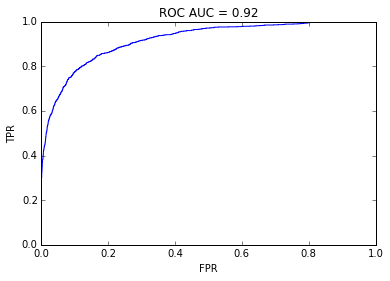

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc = roc_auc_score(test_labels, prob[:, 1])
fpr, tpr, _ = roc_curve(test_labels, prob[:, 1])

plt.plot(fpr, tpr)
plt.title("ROC AUC = %.2f" % roc_auc)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()